# **Exercise 1 - Group 08 (Academic Year 2022-2023)**
 
- Erica Brisigotti (2097202)
- Ekaterina Chueva (2072050)
- Sofia Pacheco Garcia (2070771)
- Nadillia Sahputra (2070770)

## 1.1 Loading and preprocessing data

The dataset is made of two Numpy arrays, which is convenient since we'll be working with Keras. The data is represented to get an idea of its content and its main quantities are saved as variables (such as the number $N$ of samples and the dimension $L$ of each square sample).

Based on the random generation of the input, we are confident that the data is already shuffled and contains no averages to be removed. Therefore we just upload it and split it into training and test sets based on a defined percentage.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import SGD
from scikeras.wrappers import KerasClassifier


import matplotlib as mpl
mpl.rc('image', cmap='copper')
import matplotlib.pyplot as plt
# default font
plt.rcParams['font.size'] = 15

%run nonlinear_function.py

# training data
perc_train = 0.8

2
[-31.60811883 -29.54397214] 0.0
[6.77250291 9.5544703 ] 1.0
[46.45145197 15.31770969] 1.0
[24.89066375 15.35698709] 0.0
[24.77148093 46.13067361] 1.0
[-49.16117021 -39.35556233] 0.0
[-20.12962862  15.64111831] 1.0
[30.98125525 37.21759137] 1.0
[46.46475974 22.36853469] 1.0
[14.24753279 21.74536208] 0.0
data: 4000
train: 3200


<function matplotlib.pyplot.show(close=None, block=None)>

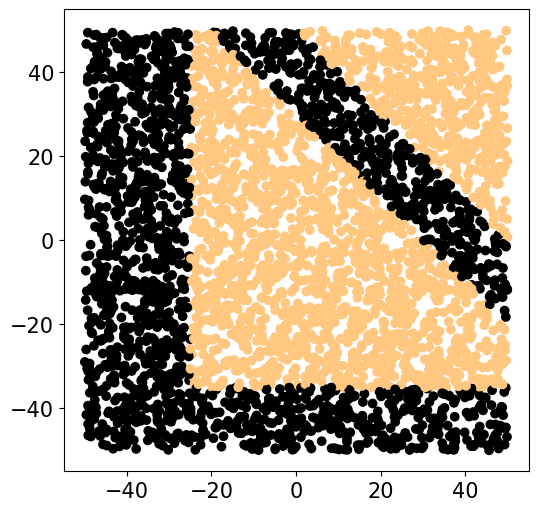

In [2]:
# Keras works with numpy arrays: just use them from the start
TYPE=1
x = np.loadtxt(filename("data",TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",TYPE), delimiter=' ')
N = len(x)

# dim. of a sample
L = len(x[0])
print(L)

for i in range(10):
    print(x[i],y[i])

N_train = int(perc_train * N)
print(f'data: {N}\ntrain: {N_train}')

plt.figure(figsize = (6,6))
plt.scatter(x[:,0],x[:,1],c=y)
plt.show

In [3]:
(x_train, y_train) = (x[0:N_train],y[0:N_train])
(x_valid, y_valid) = (x[N_train:],y[N_train:])
print("Train:",len(x_train),"\t Validation:",len(x_valid))

Train: 3200 	 Validation: 800


To avoid overrepresentation of large values, we decide to rescale each of the arrays we just obstained: this goal is achieved through the function <code>Rescale()</code>, which divides each array by the semi-length $l$ of the side of the area visible in the first example plot.

In [4]:
def Rescale(x):
    return x/50

x_train = Rescale(x_train)
x_valid = Rescale(x_valid)

## 1.2 Introduction to the model and its architecture

The Deep Neural Network is then constructed by initiating a model (through Keras' <code>Sequential()</code> function) and attaching layers to it one by one (via its method <code>add()</code> ).
The first layer's shape must be coherent to the shape of each sample $L$, and the last layer's shape must be unitary since it returns a probability. The number of neurons for the remaining layers is arbitrary and multiple values have been considered (in this case, <code>[10, 15, 20]</code>) to ultimately find the optimal choice through a Grid Search algorithm. The total numbers of layers of the network is also an arbitrary quantity, which was set to 5.

Similar considerations can be made for the choice of activation function: the activation functions for the first layers can be varied (e.g. <code>sigmoid</code>, <code>relu</code> and <code>elu</code>) to see the find the optimal choice through a Grid Search algorithm. Instead, the last layer may implement a different activation function, such as the <code>Sigmoid</code> activation function, which allows for the normalization of the output of the network and its interpretation as a probability distribution.

At this step, we look out for overfitting by applying Keras' <code>Dropout()</code> at the end of the network.

The choice of a <code>binary_crossentropy</code> cost function is due to the binary nature of classification problem. Similarly, choosing <code>accuracy</code> (i.e.the percentage of correctly classified data points) as the metrix is a straight-forward choice for categorical tasks. 

The optimization through a Grid Search algorithm will also comprehend the choice of the gradient descent algorithms (e.g. <code>ADAM</code>, <code>RMSprop</code> and <code>SGD</code>).

In [5]:
# model 1 
def create_model(optimizer='sgd', activation ='sigmoid', neurons = 20):
 # create model
    model = Sequential()
    model.add(Dense(L,input_shape=(L,),activation=activation))
    model.add(Dense(neurons,activation=activation))
    model.add(Dense(neurons,activation=activation))
    model.add(Dense(neurons,activation=activation))
    model.add(Dropout(0.01))
    model.add(Dense(1,activation='sigmoid'))
    nepoch=400
 # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

## 1.3 Gridsearch algorithm implementation


We now perform a grid-search algorithm by variying 3 of the parameters of the model that we've already introduced 
- the activation function between <code>sigmoid</code>, <code>relu</code> and <code>elu</code>
- the gradient descent algorithm between <code>ADAM</code>, <code>RMSprop</code> and <code>SGD</code>
- the number of neurons for each inner layer of the network between <code>[10,15,20]</code>

In [6]:
# fix random seed for reproducibility
np.random.seed(2072050)
import tensorflow.random as tf_r
tf_r.set_seed(2072050)

# create model
model = KerasClassifier(model=create_model, epochs=100, batch_size=50, verbose=0)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adam']
activation = [ 'sigmoid','relu','elu']
neurons = [10,15,20]

param_grid = dict(model__optimizer=optimizer, model__activation = activation, model__neurons = neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
results = pd.concat([pd.DataFrame(grid.cv_results_["params"]),
                     pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
display(results)

Best: 0.971252 using {'model__activation': 'elu', 'model__neurons': 20, 'model__optimizer': 'Adam'}


,model__activation,model__neurons,model__optimizer,Accuracy
0,sigmoid,10,SGD,0.517500
1,sigmoid,10,RMSprop,0.741253
2,sigmoid,10,Adam,0.756567
3,sigmoid,15,SGD,0.517500
4,sigmoid,15,RMSprop,0.738129
5,sigmoid,15,Adam,0.760005
6,sigmoid,20,SGD,0.517500
7,sigmoid,20,RMSprop,0.743749
8,sigmoid,20,Adam,0.760317
9,relu,10,SGD,0.766564


## 2. Performance analysis based on size of the data

Having now found the optimal combination of activation function, gradient descent algorithm and number of neurons per layer, we can further experiment with the input data to get even better performance: the strategies implemented consist of the variation of the size of the whole input data through reduction and increase, and data augmentation.

In [7]:
activation = (list(grid_result.best_params_.values())[0])
neurons = (list(grid_result.best_params_.values())[1])
optimizer = (list(grid_result.best_params_.values())[2])

### 2.1 Reduced data

In this case we use 40% of the original data and split it into training and validation set.

In [8]:
model_b = Sequential()
model_b.add(Dense(L,input_shape=(L,),activation=activation))
model_b.add(Dense(neurons,activation=activation))
model_b.add(Dense(neurons,activation=activation))
model_b.add(Dense(neurons,activation=activation))
model_b.add(Dropout(0.01))
model_b.add(Dense(1,activation='sigmoid'))
nepoch=400
model_b.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [9]:
p_train = 0.8
N_reduced = int(0.4*N)
N_train_reduced = int(p_train * N_reduced)
(x_train1, y_train1) = (x[0:N_train_reduced], y[0:N_train_reduced])
(x_valid1, y_valid1) = (x[N_train_reduced:N_reduced], y[N_train_reduced:N_reduced])
x_train1 = Rescale(x_train1)
x_valid1 = Rescale(x_valid1)

In [10]:
model_fit1 = model_b.fit(x_train1, y_train1, epochs = nepoch, batch_size = 50,
                        validation_data=(x_valid1, y_valid1), verbose=0)

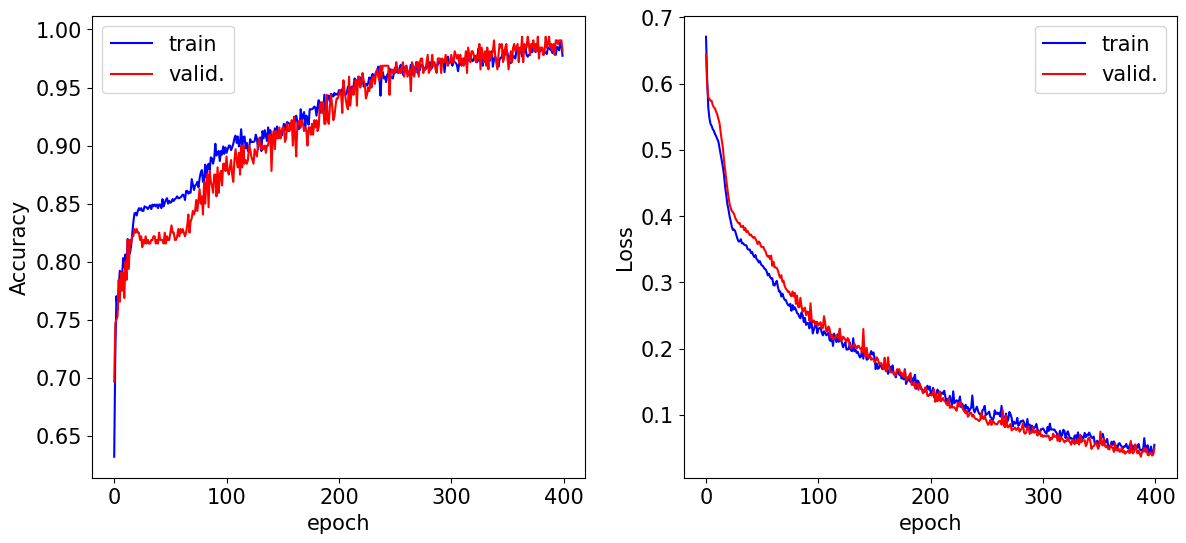

In [11]:
def accuracy_loss(model_fit):

    fig,AX=plt.subplots(1,2,figsize=(14,6.))
    ax=AX[0]
    ax.plot(model_fit.history['accuracy'],label="train",c="b")
    ax.plot(model_fit.history['val_accuracy'],label="valid.",c="r")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.legend()
    ax=AX[1]
    ax.plot(model_fit.history['loss'],label="train",c="b")
    ax.plot(model_fit.history['val_loss'],label="valid.",c="r")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.legend()
    
accuracy_loss(model_fit1)

In [12]:
dX = 2
X1 = np.arange(-50,50+dX, dX)
LG = len(X1)
grid = np.zeros((LG*LG,2))
k=0
for i in range(LG):
    for j in range(LG):
        grid[k,:]=(X1[j],X1[i])
        k=k+1
print(len(X1),len(grid))
print(grid[-1])

# RESCALE
grid_r = grid/50

pred = model_b.predict(grid_r)

51 2601
[50. 50.]
82/82 [==============================] - 0s 2ms/step


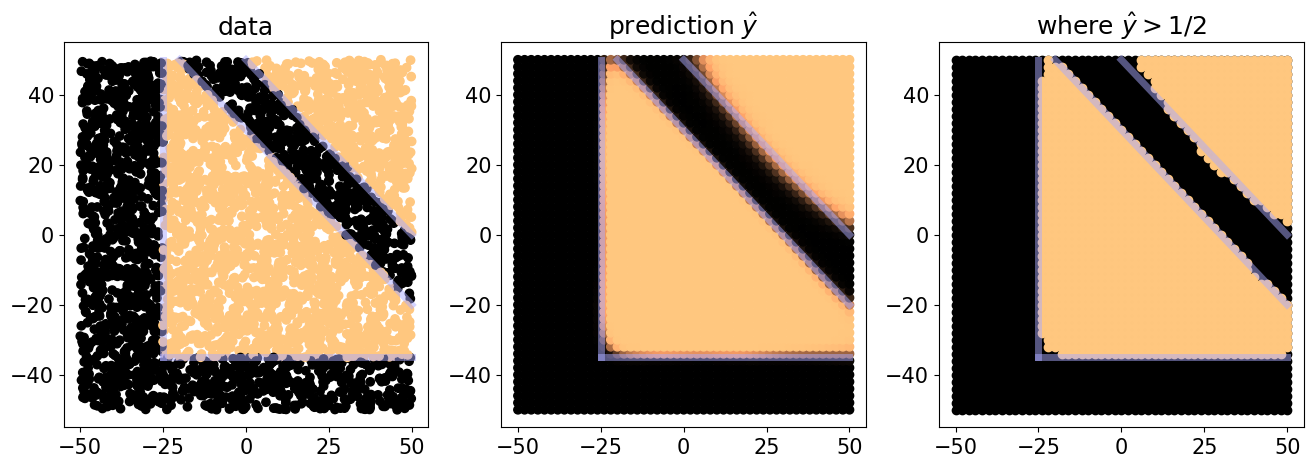

In [13]:
def boundaries(ax):  
    x1=-25
    y1=-35
    c="#AAAAFF"
    a=0.5
    lw=5
    ax.plot((50,-20),(-20,50),c=c,alpha=a,lw=lw)
    ax.plot((50,0),(0,50),c=c,alpha=a,lw=lw)
    ax.plot((x1,50),(y1,y1),c=c,alpha=a,lw=lw)
    ax.plot((x1,x1),(y1,50),c=c,alpha=a,lw=lw)
    
def plot_classification(grid, pred):
    
    fig,AX=plt.subplots(1,3,figsize=(16,5.))
    ax=AX[0]
    ax.scatter(x[:,0],x[:,1],c=y)
    boundaries(ax)
    ax.set_title("data")
    ax=AX[1]
    ax.scatter(grid[:,0],grid[:,1],c=pred)
    boundaries(ax)
    ax.set_title("prediction $\\hat y$")
    ax=AX[2]
    W1=np.where(pred>0.5)[0] 
    ax.scatter(grid[:,0],grid[:,1],c="#000000")
    ax.scatter(grid[W1,0],grid[W1,1],c="#ffc77f")
    boundaries(ax)
    ax.set_title("where $\\hat y > 1/2$")
    plt.show
    
plot_classification(grid, pred)

The model reaches highest accuracy around 200th epoch.

### 2.2 Increased data

Here we use all the available data and split into training and validation set.

In [14]:
model_b = Sequential()
model_b.add(Dense(L,input_shape=(L,),activation=activation))
model_b.add(Dense(neurons,activation=activation))
model_b.add(Dense(neurons,activation=activation))
model_b.add(Dense(neurons,activation=activation))
model_b.add(Dropout(0.01))
model_b.add(Dense(1,activation='sigmoid'))
nepoch=400
model_b.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [15]:
p_train = 0.8
N_train = int(p_train * N)
(x_train2, y_train2) = (x[0:N_train], y[0:N_train])
(x_valid2, y_valid2) = (x[N_train:N], y[N_train:N])
x_train2 = Rescale(x_train2)
x_valid2 = Rescale(x_valid2)

In [16]:
model_fit2 = model_b.fit(x_train2, y_train2, epochs = nepoch, batch_size = 50,
                        validation_data=(x_valid2, y_valid2), verbose=0)

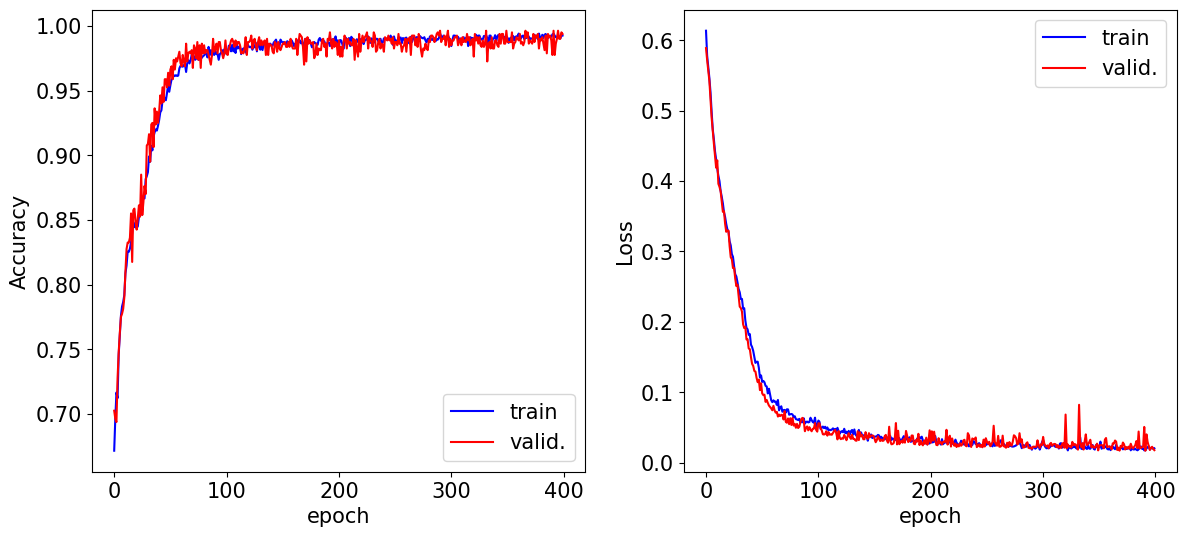

In [17]:
accuracy_loss(model_fit2)

In [18]:
#grid is the same as before

pred = model_b.predict(grid_r)

82/82 [==============================] - 0s 2ms/step


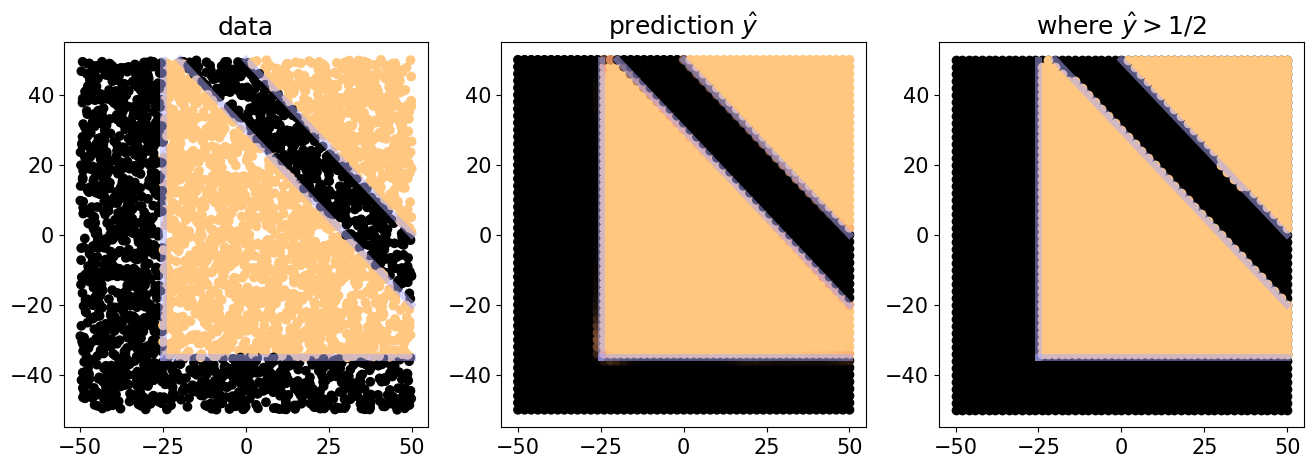

In [19]:
plot_classification(grid, pred)

With increased dataset we reach highest accuracy almost twice faster than before (around 100th epoch).

### 2.3 Augmented data

In this case we use data augmentation: we add some minor random noise (not more than 1% of the original value). With the choice like this we only slightly change the original dataset and do not 

This tecnique is used to artificially increase the dataset in order to make the performance of DNN better. There is no point in augmenting of the validation set, because it does not increase the accuracy of the model and, furthermore, we would like to test the model on an original data.

In [20]:
model_b = Sequential()
model_b.add(Dense(L,input_shape=(L,),activation=activation))
model_b.add(Dense(neurons,activation=activation))
model_b.add(Dense(neurons,activation=activation))
model_b.add(Dense(neurons,activation=activation))
model_b.add(Dropout(0.01))
model_b.add(Dense(1,activation='sigmoid'))
nepoch=400
model_b.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [21]:
p_train = 0.8 
N_train = int(p_train * N)
noise = (np.random.random((N_train,2)) - 0.5)

(x_train, y_train) = (x[0:N_train], y[0:N_train])
x_extra = np.copy(x_train)+noise
y_extra = np.copy(y_train)
x_train3 = np.concatenate((x_train, x_extra))
y_train3 = np.concatenate((y_train, y_extra))
(x_valid3, y_valid3) = (x[N_train:N], y[N_train:N])

x_train3 = Rescale(x_train3)
x_valid3 = Rescale(x_valid3)

print("Train:",len(x_train3),"\t Validation:",len(x_valid3))

Train: 6400 	 Validation: 800


In [22]:
model_fit3 = model_b.fit(x_train3, y_train3,epochs = nepoch, batch_size = 50,
                        validation_data=(x_valid3, y_valid3), verbose=0)

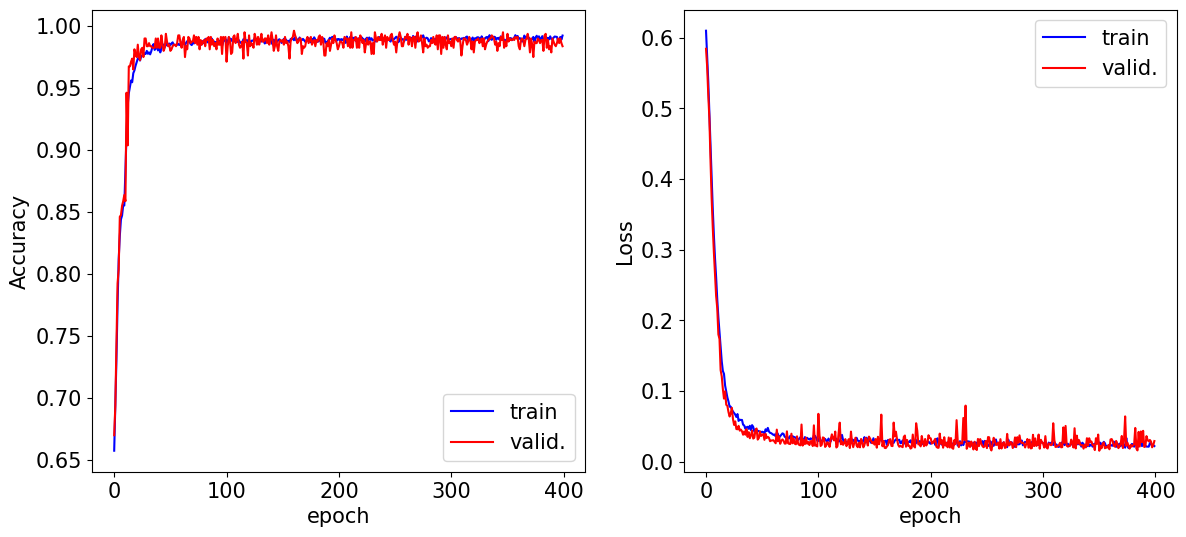

In [23]:
accuracy_loss(model_fit3)

In [24]:
#grid is the same as before

pred = model_b.predict(grid_r)

82/82 [==============================] - 0s 2ms/step


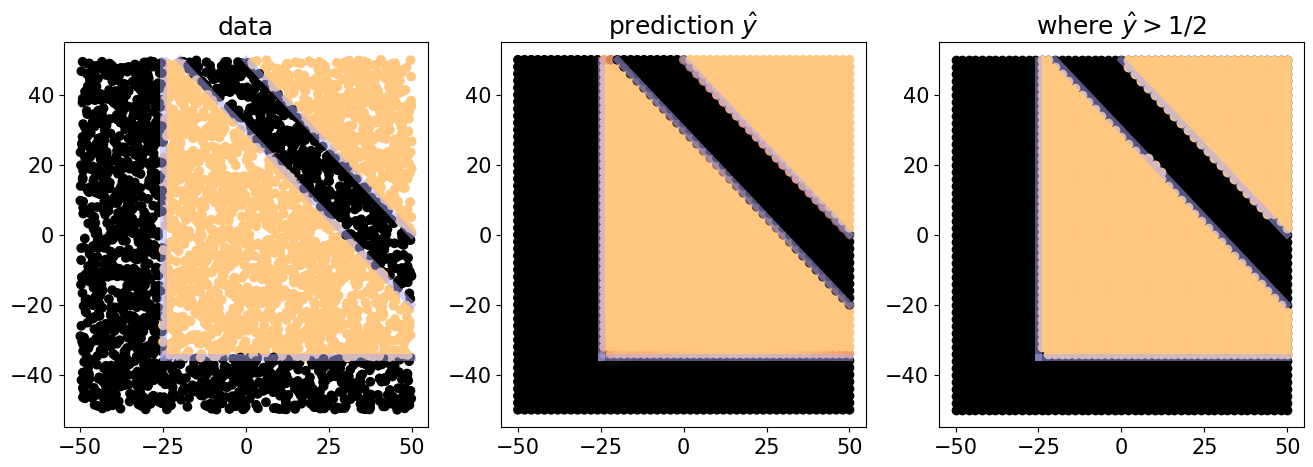

In [25]:
plot_classification(grid, pred)

With data augmentation the model achieves the highest accuracy even faster than in the second case.

## 3. Conclusions

In this work we found the best combination of activation function, gradient descent algorithm and number of neurons per layer for the DNN.

Moreover, we found that data augmentation is the best technique to achieve the highest accuracy as fast as possible. This gives us an opportunity to train our model for the less number of epochs (reduce time of programme running).